In [1]:
import sys
sys.path.insert(0, '../../')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.dspn import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
from data .Modelnet10toSet import *
from data .pointcloud_utils import *
import matplotlib.pyplot as plt
import random
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

In [2]:
batch_size = 32
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [3]:
class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

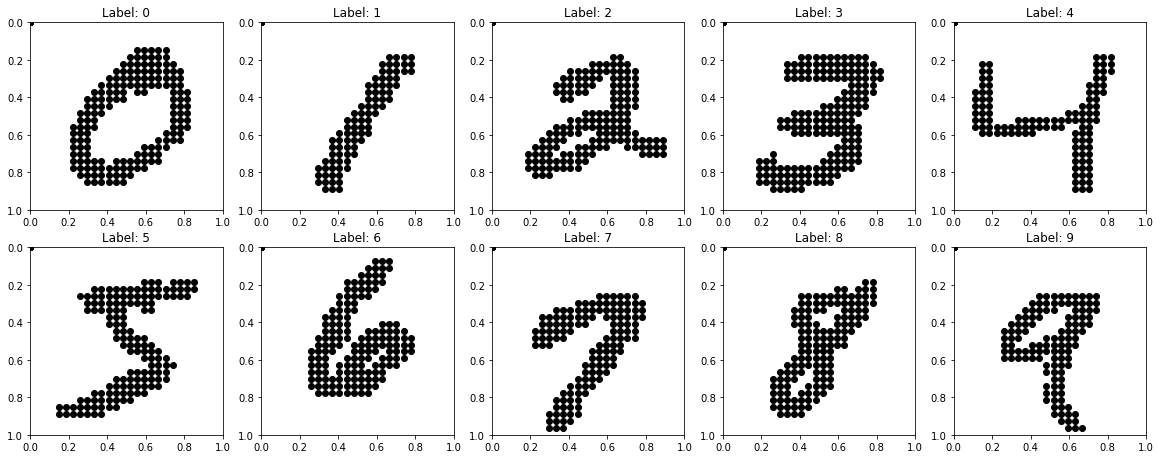

In [4]:
dataset_mnist_set = MNISTSet(full=True)
class_names =   [ 0 , 1 , 2,  3 , 4 , 5 , 6 , 7 ,  8 ,  9]
class_names2 = [torch.Tensor(0),torch.Tensor(1),torch.Tensor(2),torch.Tensor(0),torch.Tensor(3),torch.Tensor(4),torch.Tensor(5),torch.Tensor(6),torch.Tensor(7),torch.Tensor(8),torch.Tensor(9)]
sampleSet = []
sampleMask = []
sampleSetDSPN = []
sampleMaskDSPN = []
for i in range(len(class_names)):
    for j in range(len(dataset_mnist_set)):
        if i == dataset_mnist_set[j][0]:
            sampleSet.append(dataset_mnist_set[j][1])
            sampleMask.append(dataset_mnist_set[j][2])
            sampleSetDSPN.append(dataset_mnist_set[j][1].unsqueeze(0))
            sampleMaskDSPN.append(dataset_mnist_set[j][2].unsqueeze(0))
            break
fig = plt.figure(figsize=(20, 20))

for i,set in enumerate(sampleSet):
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

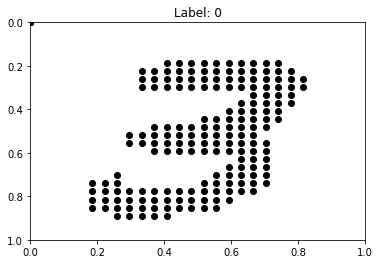

In [5]:
for i,set in enumerate(sampleSet[3:4]):
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

In [6]:
sampleSetDSPN[0].shape

torch.Size([1, 2, 342])

In [7]:
set_channels = 2
set_size = 342
hidden_dim = 32
latent_dim = 16
lr = 0.001
iters = 10
inner_lr = 1
n_epochs = 50
set_encoder = SumEncoderDSPN(set_channels, latent_dim, hidden_dim)
set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
net = Net(input_encoder=None, set_encoder=set_encoder, set_decoder=set_decoder)
model1 = net.set_decoder.encoder

In [8]:
m = torch.ones(1,342)
m.shape
print(net.set_decoder.encoder(sampleSet[8].unsqueeze(0),m))
net.set_decoder.encoder.salidaConv.shape

tensor([[-107.9536,   69.8907,   -6.2638,   -3.4964,   42.1361,   19.2087,
          -61.7441,   -0.7227,    3.6640,   34.1892,   75.2958,  -28.1173,
           11.0003,  111.5845,   43.2315,   45.3064,    0.3360,    2.2503,
           41.5629,   97.2181,  -24.4200,   -8.4365,   38.6239,   -7.7242,
          -75.1464,  136.9192,  -36.4353,  -28.3329,  -11.8758,   81.4730,
          -72.9346,   28.4859]], grad_fn=<SumBackward1>)


torch.Size([1, 32, 342])

In [9]:
def plotProgressCrit():
    fig = plt.figure(figsize=(20, 20))
    for i,set in enumerate(sampleSet):
        crit = critical_points_MaxEncoder(model1,set)
        ax = fig.add_subplot(5, 5, i+1)
        x = set[1, :]
        y = set[0, :]
        plt.scatter(x, y,color = 'c',s=40)
        x = crit[1, :]
        y = crit[0, :]
        plt.scatter(x, y,marker='o',color = 'r',s=70)
        plt.axis([0, 1, 1, 0])
        plt.title('Puntos Criticos')
    plt.show()

In [10]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    m = torch.ones(1,342)
    pred = model(sample.unsqueeze(0),m)
    features_map = model.salidaConv.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    rango = len(newxmaxargs)
    for k in range(rango):
        #if not (points[0,newxmaxargs[k]]==0. and points[1,newxmaxargs[k]] ==0.):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])

    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [11]:
global_crit = 0
def plot_inner_loop(progress_only):
    fig = plt.figure(figsize=(20, 20))
    for i,set in enumerate(progress_only[10:]):
        crit = critical_points_MaxEncoder(model1,set.squeeze(0).detach())
        global_crit = crit.copy()
        ax = fig.add_subplot(5, 5, i+1)
        x = set.squeeze(0).detach()[1, :]
        y = set.squeeze(0).detach()[0, :]
        plt.scatter(x, y,color = 'c',s=40)
        x = crit[1, :]
        y = crit[0, :]
        plt.scatter(x, y,marker='o',color = 'r',s=70)
        plt.axis([0, 1, 1, 0])
        plt.title('Puntos Criticos')
    plt.show()

In [12]:
def plot_inner_loop_not_crit(progress_only):
    fig = plt.figure(figsize=(20, 20))
    for i,set in enumerate(progress_only[10:]):
        #crit = critical_points_MaxEncoder(model1,set.squeeze(0).detach())
        ax = fig.add_subplot(5, 5, i+1)
        x = set.squeeze(0).detach()[1, :]
        y = set.squeeze(0).detach()[0, :]
        plt.scatter(x, y,color = 'k',s=40)
        plt.axis([0, 1, 1, 0])
        #plt.title('Puntos Criticos')
        plt.axis('off')
    plt.show()

Traning using  cpu
Net(
  (set_encoder): SumEncoderDSPN(
    (conv): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (set_decoder): DSPN(
    (encoder): SumEncoderDSPN(
      (conv): Sequential(
        (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
        (1): ReLU(inplace=True)
        (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      )
    )
  )
)
loss:  0.00079


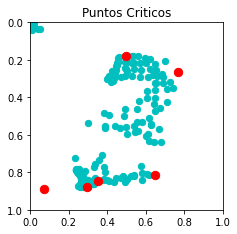

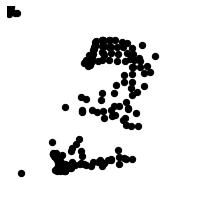

loss:  0.00104
loss:  0.00094
loss:  0.00089
loss:  0.00065
loss:  0.00068
loss:  0.00066
loss:  0.00061
loss:  0.00053
loss:  0.00051
loss:  0.0005
loss:  0.00049
loss:  0.00046
loss:  0.00046
loss:  0.00041
loss:  0.00038
loss:  0.00037
loss:  0.00037
loss:  0.00036
loss:  0.00034
loss:  0.00032
loss:  0.00031
loss:  0.0003
loss:  0.00029
loss:  0.00027
loss:  0.00024
loss:  0.00022
loss:  0.00023
loss:  0.0002
loss:  0.0002
loss:  0.0002
loss:  0.0002
loss:  0.00018
loss:  0.00017
loss:  0.00019
loss:  0.00023
loss:  0.00027
loss:  0.00026
loss:  0.00022
loss:  0.00017
loss:  0.00013
loss:  0.00012
loss:  0.00012
loss:  0.00013
loss:  0.00013
loss:  0.00013
loss:  0.00013
loss:  0.00013
loss:  0.00014
loss:  0.00014
loss:  0.00013


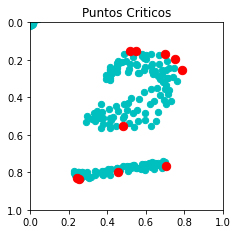

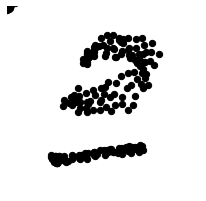

loss:  0.00014
loss:  0.00016
loss:  0.00015
loss:  0.00016
loss:  0.00016
loss:  0.00017
loss:  0.00017
loss:  0.00016
loss:  0.00015
loss:  0.00013
loss:  0.00012
loss:  0.00011
loss:  0.00011
loss:  0.0001
loss:  0.0001
loss:  0.0001
loss:  9e-05
loss:  9e-05
loss:  9e-05
loss:  8e-05
loss:  8e-05
loss:  8e-05
loss:  7e-05
loss:  7e-05
loss:  7e-05
loss:  7e-05
loss:  6e-05
loss:  6e-05
loss:  6e-05
loss:  6e-05
loss:  6e-05
loss:  5e-05
loss:  5e-05
loss:  5e-05
loss:  5e-05
loss:  5e-05
loss:  5e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05
loss:  4e-05


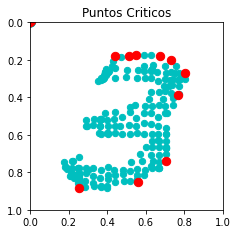

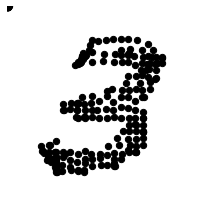

In [16]:
optimizer = torch.optim.Adam(
[p for p in net.parameters() if p.requires_grad], lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Traning using ',device)
net.train()
print(net)
criticos = []
mask = torch.ones(342).float().unsqueeze(0)
#plotProgressCrit()
for epoch in range(100):
    #for  i, sample in enumerate(test_loader):
    model1 = net.set_decoder.encoder
    label = class_names2[3].unsqueeze(0)
    set = sampleSetDSPN[3]
    target_mask = sampleMaskDSPN[3]
    (progress, masks, evals, gradn), (y_enc, y_label) = net(label, set, target_mask)
    #criticos.append(critical_points_MaxEncoder(net.set_decoder.encoder.salidaConv,sampleSet[i]))
    progress_only = progress
    set = torch.cat([set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [torch.cat([p, m.unsqueeze(dim=1)], dim=1)
                    for p, m in zip(progress, masks)]
    set_loss = chamfer_loss(torch.stack(progress), set.unsqueeze(0))
    repr_loss = F.smooth_l1_loss(y_enc, y_label)
    #print("ojoo",repr_loss.item())
    loss = set_loss.mean() +  repr_loss.mean()
    print("loss: ",round(loss.item(),5))
    progress = progress_only
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch == 0:
        plot_inner_loop(progress_only)
        plot_inner_loop_not_crit(progress_only)
    if epoch == 50:
        plot_inner_loop(progress_only)
        plot_inner_loop_not_crit(progress_only)
    if epoch == 99:
        plot_inner_loop(progress_only)
        plot_inner_loop_not_crit(progress_only)
global_crit = critical_points_MaxEncoder(model1,progress_only[10].squeeze(0).detach())


In [17]:
print(torch.Tensor(global_crit).size(1))
model1 = net.set_decoder.encoder
label = class_names2[3].unsqueeze(0)
set = torch.Tensor(global_crit).unsqueeze(0)
target_mask = torch.ones(1,torch.Tensor(global_crit).size(1))
(progress, masks, evals, gradn), (y_enc, y_label) = net(label, set, target_mask)

13


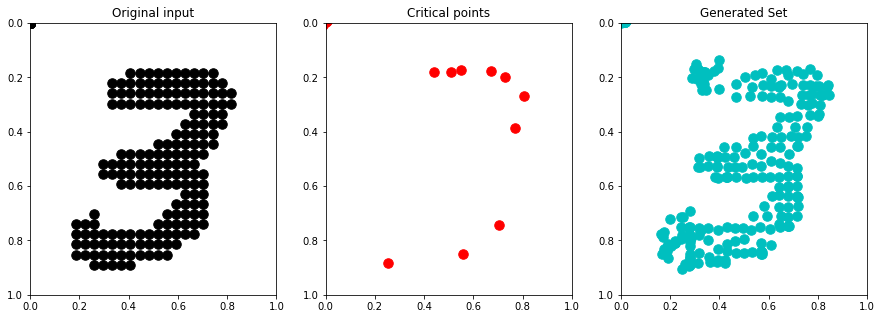

In [18]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
x = sampleSet[3][1, :]
y = sampleSet[3][0, :]
plt.scatter(x, y,color = 'k',s=90)
plt.axis([0, 1, 1, 0])
plt.title("Original input")
ax = fig.add_subplot(1, 3, 2)
x = global_crit[1, :]
y = global_crit[0, :]
plt.scatter(x, y,color = 'r',s=90)
plt.axis([0, 1, 1, 0])
plt.title("Critical points")
ax = fig.add_subplot(1, 3, 3)
x = progress[0].squeeze(0).detach()[1, :]
y = progress[0].squeeze(0).detach()[0, :]
plt.scatter(x, y,color = 'c',s=90)
plt.axis([0, 1, 1, 0])
plt.title("Generated Set")
plt.show()